In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:38 - loss: 0.1065 - STD: 9.4659e-05 - MAE: 0.3143

 11/632 [..............................] - ETA: 3s - loss: 0.0353 - STD: 2.3570e-04 - MAE: 0.1439   

 21/632 [..............................] - ETA: 3s - loss: 0.0261 - STD: 2.5782e-04 - MAE: 0.1206

 31/632 [>.............................] - ETA: 3s - loss: 0.0219 - STD: 2.6601e-04 - MAE: 0.1031

 41/632 [>.............................] - ETA: 3s - loss: 0.0199 - STD: 3.0238e-04 - MAE: 0.0956

 52/632 [=>............................] - ETA: 3s - loss: 0.0185 - STD: 3.7134e-04 - MAE: 0.0908

 63/632 [=>............................] - ETA: 2s - loss: 0.0173 - STD: 4.8745e-04 - MAE: 0.0868

 74/632 [==>...........................] - ETA: 2s - loss: 0.0167 - STD: 6.9760e-04 - MAE: 0.0843

 84/632 [==>...........................] - ETA: 2s - loss: 0.0162 - STD: 0.0011 - MAE: 0.0828    

 94/632 [===>..........................] - ETA: 2s - loss: 0.0156 - STD: 0.0018 - MAE: 0.0808

104/632 [===>..........................] - ETA: 2s - loss: 0.0151 - STD: 0.0035 - MAE: 0.0788

113/632 [====>.........................] - ETA: 2s - loss: 0.0144 - STD: 0.0065 - MAE: 0.0766

123/632 [====>.........................] - ETA: 2s - loss: 0.0137 - STD: 0.0113 - MAE: 0.0739

133/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 0.0167 - MAE: 0.0712

143/632 [=====>........................] - ETA: 2s - loss: 0.0123 - STD: 0.0221 - MAE: 0.0689

153/632 [======>.......................] - ETA: 2s - loss: 0.0117 - STD: 0.0268 - MAE: 0.0667

163/632 [======>.......................] - ETA: 2s - loss: 0.0112 - STD: 0.0311 - MAE: 0.0648

173/632 [=======>......................] - ETA: 2s - loss: 0.0107 - STD: 0.0350 - MAE: 0.0631

183/632 [=======>......................] - ETA: 2s - loss: 0.0103 - STD: 0.0383 - MAE: 0.0615

193/632 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0414 - MAE: 0.0601

203/632 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0441 - MAE: 0.0587

213/632 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 0.0467 - MAE: 0.0575

214/632 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 0.0469 - MAE: 0.0574

227/632 [=========>....................] - ETA: 3s - loss: 0.0088 - STD: 0.0499 - MAE: 0.0559

239/632 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0523 - MAE: 0.0547

251/632 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.0548 - MAE: 0.0535

263/632 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.0570 - MAE: 0.0525

273/632 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.0587 - MAE: 0.0517

283/632 [============>.................] - ETA: 2s - loss: 0.0074 - STD: 0.0600 - MAE: 0.0509

293/632 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.0616 - MAE: 0.0502

303/632 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0629 - MAE: 0.0495

313/632 [=============>................] - ETA: 2s - loss: 0.0069 - STD: 0.0640 - MAE: 0.0489

323/632 [==============>...............] - ETA: 2s - loss: 0.0067 - STD: 0.0653 - MAE: 0.0483

333/632 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0477

343/632 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0676 - MAE: 0.0471

353/632 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0686 - MAE: 0.0466

363/632 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0695 - MAE: 0.0461

373/632 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0457

383/632 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0713 - MAE: 0.0452

393/632 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0722 - MAE: 0.0449

403/632 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0445

413/632 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0737 - MAE: 0.0441

423/632 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0437

433/632 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0433

443/632 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0430

455/632 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0427

467/632 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0423

479/632 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0419

491/632 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0416

503/632 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0413

515/632 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0409

527/632 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0406

539/632 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0403

551/632 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0401

563/632 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0398

575/632 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0396

587/632 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0393

599/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0391

612/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0839 - MAE: 0.0388

625/632 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0386

632/632 [==============================] - 5s 7ms/step - loss: 0.0043 - STD: 0.0846 - MAE: 0.0385 - val_loss: 0.0020 - val_STD: 0.0804 - val_MAE: 0.0312


Epoch 2/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

 13/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278 

 25/632 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

 37/632 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

 49/632 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

 61/632 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

 73/632 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

 85/632 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

 97/632 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

109/632 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

121/632 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

133/632 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

145/632 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

157/632 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

168/632 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

180/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

193/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

206/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

218/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

231/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

243/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

255/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

267/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

279/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

291/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

303/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

315/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

327/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

339/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

351/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

363/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

375/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

387/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

398/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

409/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

419/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

430/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

442/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

454/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

466/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

478/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

490/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

503/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

516/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

527/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

538/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

549/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

560/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

572/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

584/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

596/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

608/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

620/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

631/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

632/632 [==============================] - 3s 5ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272 - val_loss: 0.0016 - val_STD: 0.0794 - val_MAE: 0.0282


Epoch 3/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262 

 25/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0264

 37/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

 49/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0265

 61/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

 73/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

 85/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

 96/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

106/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

117/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

129/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

142/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

154/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

166/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

178/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

190/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263

214/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

226/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

238/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

251/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

262/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

272/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

282/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

292/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

304/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

316/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

328/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

340/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

352/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

364/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

377/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

390/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

403/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

416/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

428/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

461/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

481/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

493/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

518/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

528/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

538/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

548/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

558/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

568/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

579/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

590/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

601/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

613/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

624/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0015 - val_STD: 0.0812 - val_MAE: 0.0276


Epoch 4/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0273

 12/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260 

 23/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 47/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0263

 60/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

 73/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

 86/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

 98/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

111/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

123/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

135/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

147/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

159/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

170/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

181/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

194/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

206/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

230/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

241/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

252/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

262/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

273/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

283/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

293/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

303/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

313/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

324/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

335/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

346/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

357/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

368/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

379/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

389/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

399/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

410/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

420/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

430/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

441/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

464/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

477/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

489/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

501/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

513/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

534/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

544/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

564/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

574/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

585/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

595/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

606/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

617/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

627/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259 - val_loss: 0.0017 - val_STD: 0.0827 - val_MAE: 0.0284


Epoch 5/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1091 - MAE: 0.0252

 12/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1042 - MAE: 0.0254

 23/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0257

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0255

 47/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 59/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

 70/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 80/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

 90/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

100/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

110/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

120/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

130/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

141/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

151/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

162/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

175/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

188/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

200/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

212/632 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

225/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

237/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

249/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

261/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

271/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

281/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

291/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

301/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

312/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

323/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

335/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

347/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

359/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

370/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

381/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

391/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

401/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

411/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

421/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

431/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

442/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

463/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

475/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

500/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

533/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

543/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

565/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

575/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

585/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

595/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

606/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

616/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

627/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0019 - val_STD: 0.0866 - val_MAE: 0.0301


Epoch 6/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.1191 - MAE: 0.0259

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0249 

 22/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0251

 32/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

 44/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

 56/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

 67/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

 77/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

 87/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

 99/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

111/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

123/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

134/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

146/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

157/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

169/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

181/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

193/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

205/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

218/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

230/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

251/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

263/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

275/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

287/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

299/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

311/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

323/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

347/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

359/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

371/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

383/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

395/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

407/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

419/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

431/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

443/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

455/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

466/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

478/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

490/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

502/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

513/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

524/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

535/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

546/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

557/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

567/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

577/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

587/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

597/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

607/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

617/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

627/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0014 - val_STD: 0.0827 - val_MAE: 0.0263


Epoch 7/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.0934 - MAE: 0.0245

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0247 

 21/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

 32/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

 44/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

 56/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

 67/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

 79/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

104/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

114/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

125/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

137/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

149/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

162/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

175/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

188/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

201/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

214/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

227/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

252/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

264/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

276/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

286/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

298/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

310/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

323/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

348/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

361/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

374/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

386/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

398/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

409/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

420/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

432/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

444/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

456/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

468/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

480/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

515/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

527/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

539/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

551/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

562/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

573/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

583/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

593/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

603/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

613/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

623/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0014 - val_STD: 0.0842 - val_MAE: 0.0263


Epoch 8/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0011 - STD: 0.1045 - MAE: 0.0220

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247 

 22/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0245

 33/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

 44/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0241

 53/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0241

 62/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0243

 72/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0246

 82/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0247

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0248

102/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

113/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

124/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0246

134/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0246

145/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0246

156/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0246

168/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

179/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0245

190/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

202/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

214/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

226/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

238/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

250/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

262/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

274/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0243

284/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0243

294/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0243

304/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0244

314/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0244

324/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0244

335/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

347/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

358/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

368/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

378/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

388/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

398/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

408/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

418/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

428/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

438/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

448/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

458/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

468/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

478/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

488/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

498/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

508/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

519/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

532/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

544/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

554/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

564/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

575/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

587/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

598/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

610/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

622/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

632/632 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243 - val_loss: 0.0019 - val_STD: 0.0875 - val_MAE: 0.0294


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0240

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1044 - MAE: 0.0236 

 21/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

 31/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0234

 42/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

 52/632 [=>............................] - ETA: 3s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0233

 63/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0234

 73/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235

 83/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235

 93/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

103/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

113/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

123/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

133/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

143/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

154/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

166/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

179/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

192/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

204/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

217/632 [=========>....................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

230/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

242/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

266/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

290/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

302/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

313/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

334/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

344/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

354/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

364/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

374/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

386/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

397/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

407/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

418/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

429/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0237

440/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0237

450/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

461/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

472/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

483/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

494/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

505/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

515/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

525/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

536/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

548/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

559/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

571/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0237

583/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

595/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

607/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

619/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

631/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237 - val_loss: 0.0019 - val_STD: 0.0879 - val_MAE: 0.0291


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 9.8151e-04 - STD: 0.1078 - MAE: 0.0223

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1093 - MAE: 0.0243     

 21/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0241

 31/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0241

 42/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0242

 54/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0241

 66/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0239

 78/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

 89/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

101/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

113/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

124/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

136/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

148/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

160/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

172/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

184/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

195/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

205/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

215/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

235/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

245/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

256/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

267/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0235

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

290/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

301/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

312/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

322/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

333/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

345/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

357/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

369/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

381/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

393/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

405/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

417/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

429/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

441/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

453/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

491/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

503/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

515/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

527/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

539/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

551/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

563/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

575/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

587/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

599/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

611/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

623/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235 - val_loss: 0.0016 - val_STD: 0.0870 - val_MAE: 0.0275


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1179 - MAE: 0.0263

 12/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1102 - MAE: 0.0234 

 24/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1088 - MAE: 0.0231

 36/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1084 - MAE: 0.0232

 48/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1086 - MAE: 0.0232

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1088 - MAE: 0.0232

 72/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1083 - MAE: 0.0231

 84/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0232

 96/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

108/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

120/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

132/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0230

144/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0230

156/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0230

169/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

181/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

193/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

205/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

218/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

230/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

242/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

266/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

291/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

303/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

315/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

327/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

339/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

351/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

363/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

375/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

387/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

399/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

411/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

424/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

436/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

448/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

461/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

473/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

486/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

498/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

510/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

522/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

534/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

546/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

558/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

570/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

582/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

593/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

605/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

616/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

626/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231 - val_loss: 0.0018 - val_STD: 0.0879 - val_MAE: 0.0282


Epoch 12/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1138 - MAE: 0.0235

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1049 - MAE: 0.0233 

 21/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0234

 31/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0234

 43/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0232

 55/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

 67/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0234

 79/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

 91/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

103/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

115/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

127/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

139/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

151/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

163/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

175/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0231

187/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

199/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0231

211/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

223/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

235/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

247/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

259/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

271/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

283/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

295/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

307/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

320/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

333/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

345/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

356/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

368/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

379/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

390/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

400/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

410/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

420/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

430/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

442/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

454/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

488/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

498/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

508/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

518/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

538/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

548/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

560/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

572/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

584/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

597/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

609/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

629/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228 - val_loss: 0.0015 - val_STD: 0.0836 - val_MAE: 0.0267


Epoch 13/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0244

 12/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1106 - MAE: 0.0228 

 24/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1095 - MAE: 0.0226

 36/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1094 - MAE: 0.0225

 48/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1091 - MAE: 0.0225

 60/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1092 - MAE: 0.0225

 73/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1092 - MAE: 0.0226

 86/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1089 - MAE: 0.0227

 98/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1090 - MAE: 0.0228

110/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1090 - MAE: 0.0228

122/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1089 - MAE: 0.0228

135/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1089 - MAE: 0.0227

148/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1087 - MAE: 0.0226

160/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0226

173/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0226

185/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0225

197/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0225

208/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0225

220/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0226

233/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0226

246/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0226

259/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0226

272/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

284/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

296/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

309/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

322/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

334/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

347/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

359/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

371/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

383/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

395/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

407/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

419/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

431/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

443/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0227

455/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0227

467/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

480/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0227

492/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

504/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

516/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0227

528/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

540/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

552/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

564/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

576/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

589/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

601/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

613/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

625/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226 - val_loss: 0.0016 - val_STD: 0.0836 - val_MAE: 0.0271


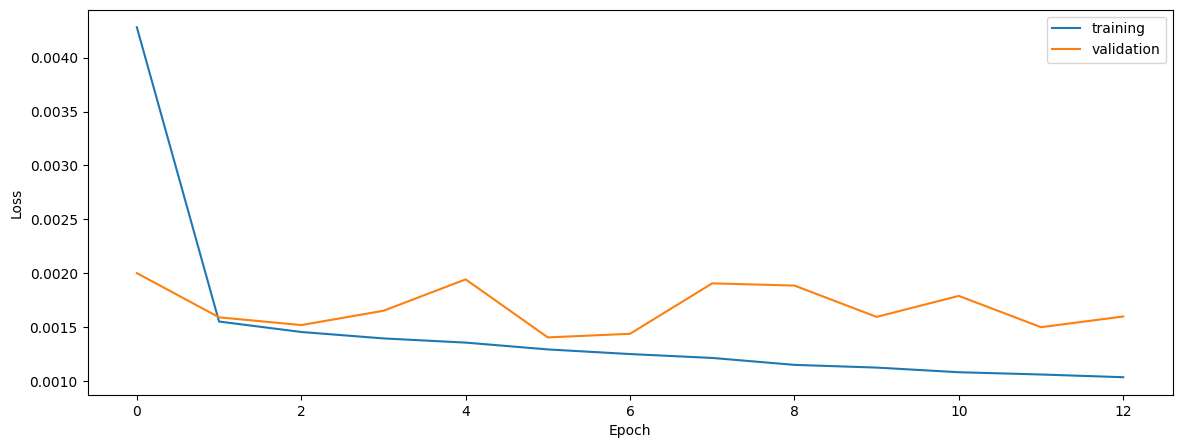

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9510619680278263
0.9586547884809868
0.9473763529546615


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9502713514888422
0.9554003133900303
0.9512214626328447


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9562903196388345
0.9567453743126532
0.962313938039803


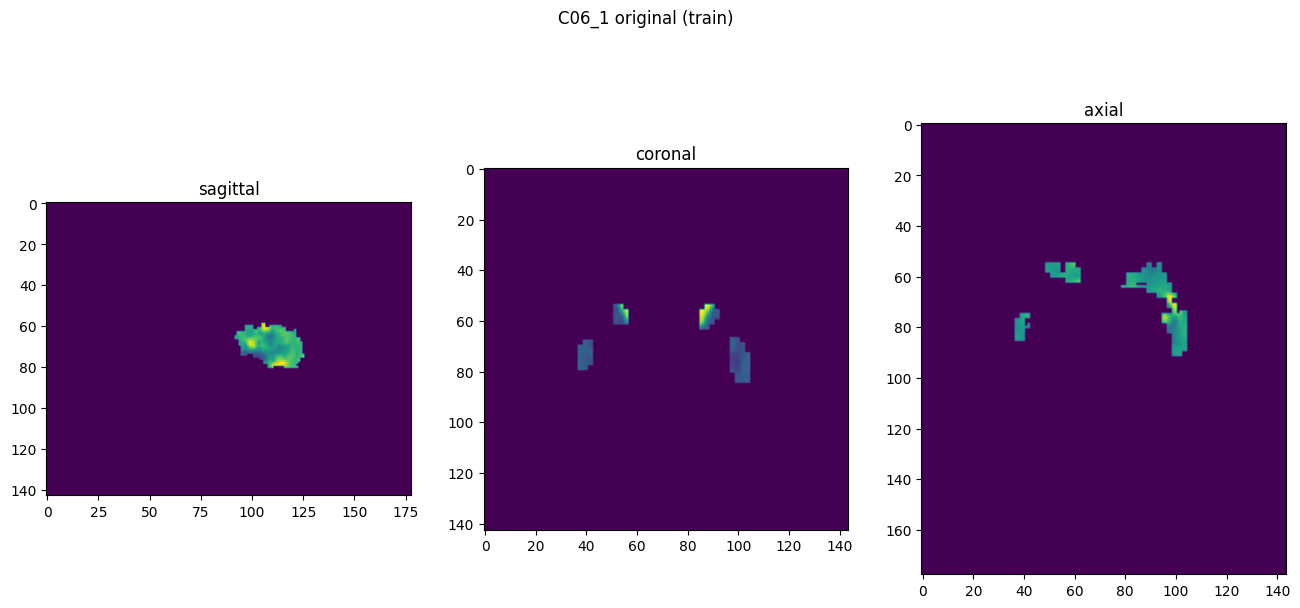

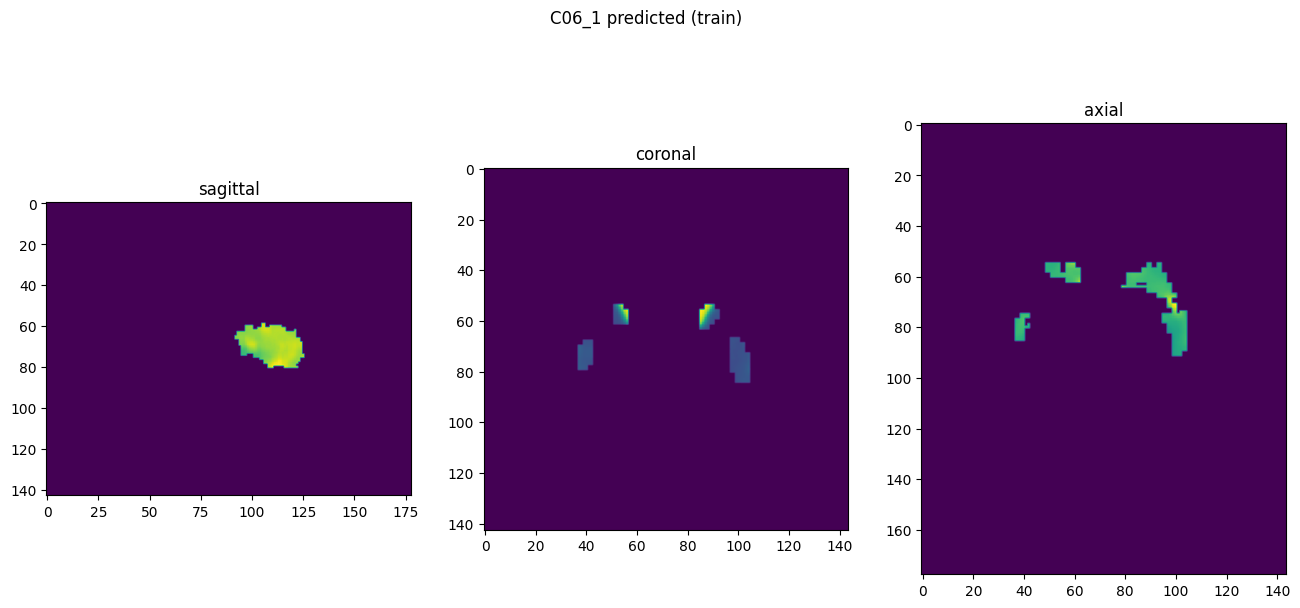

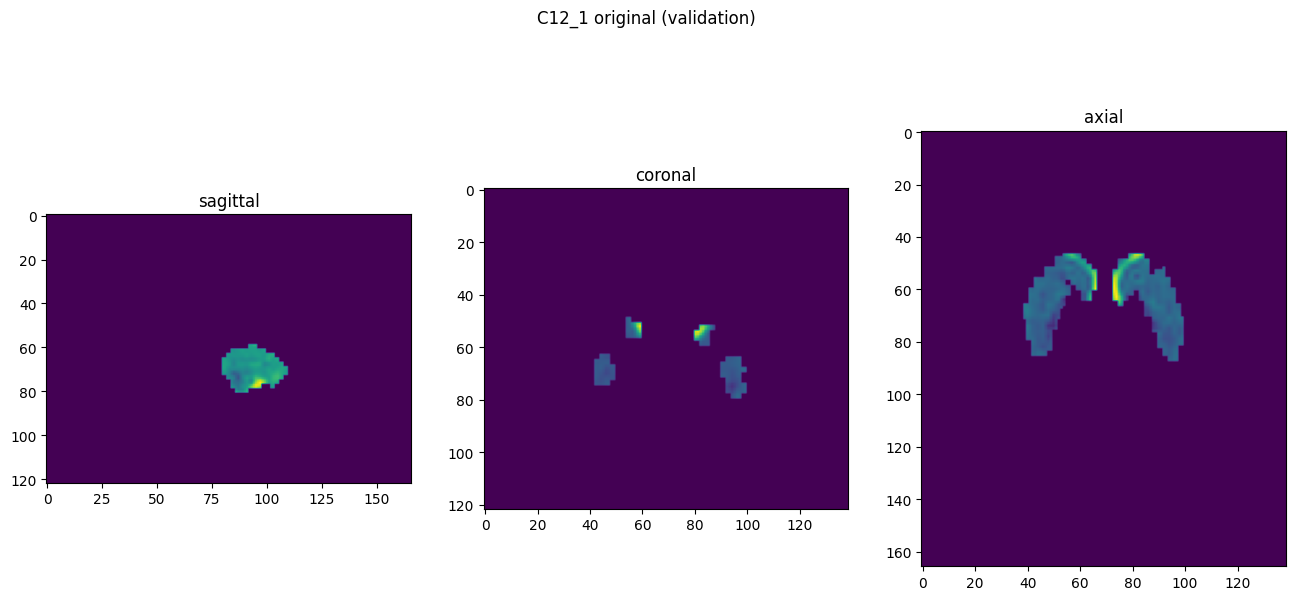

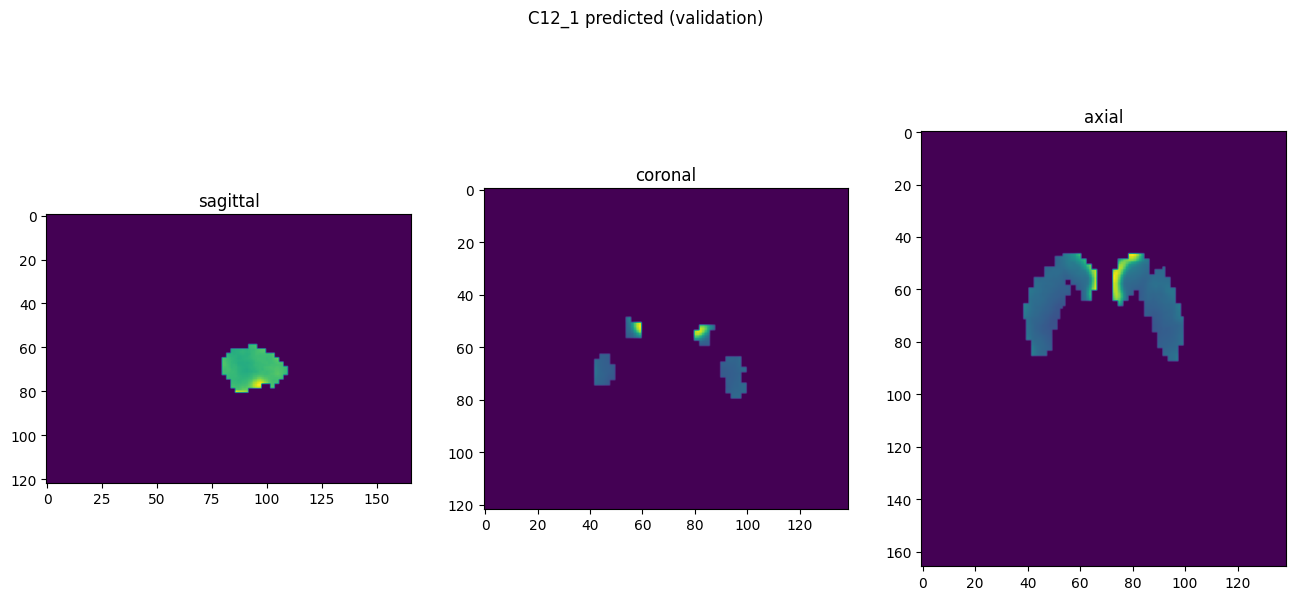

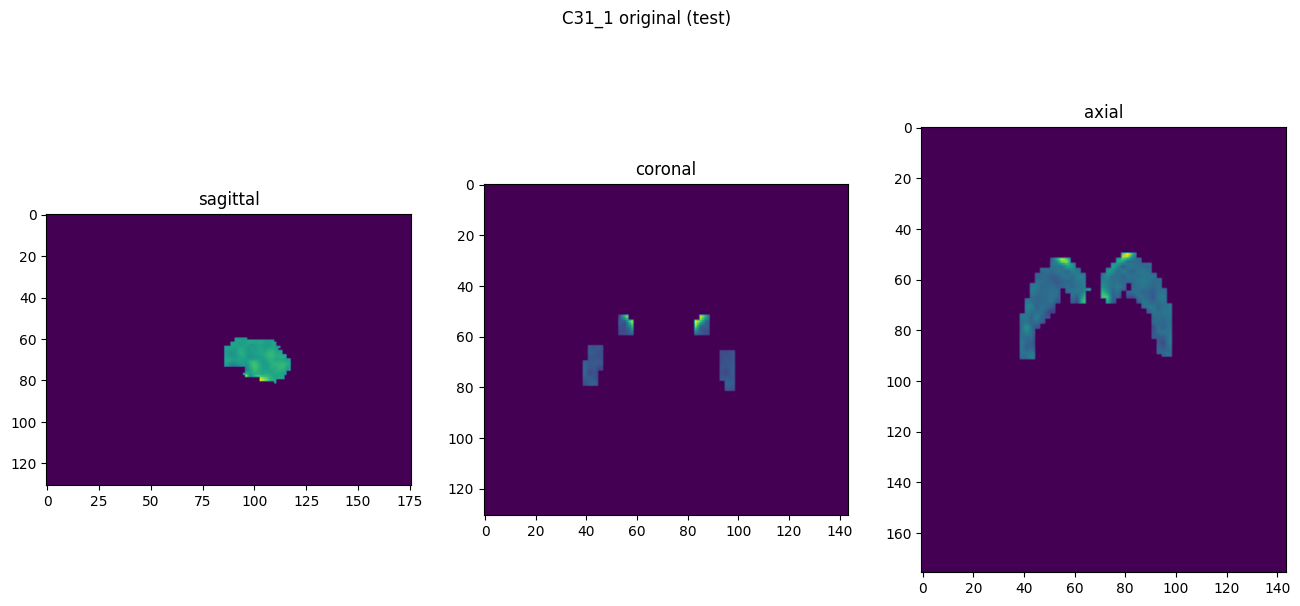

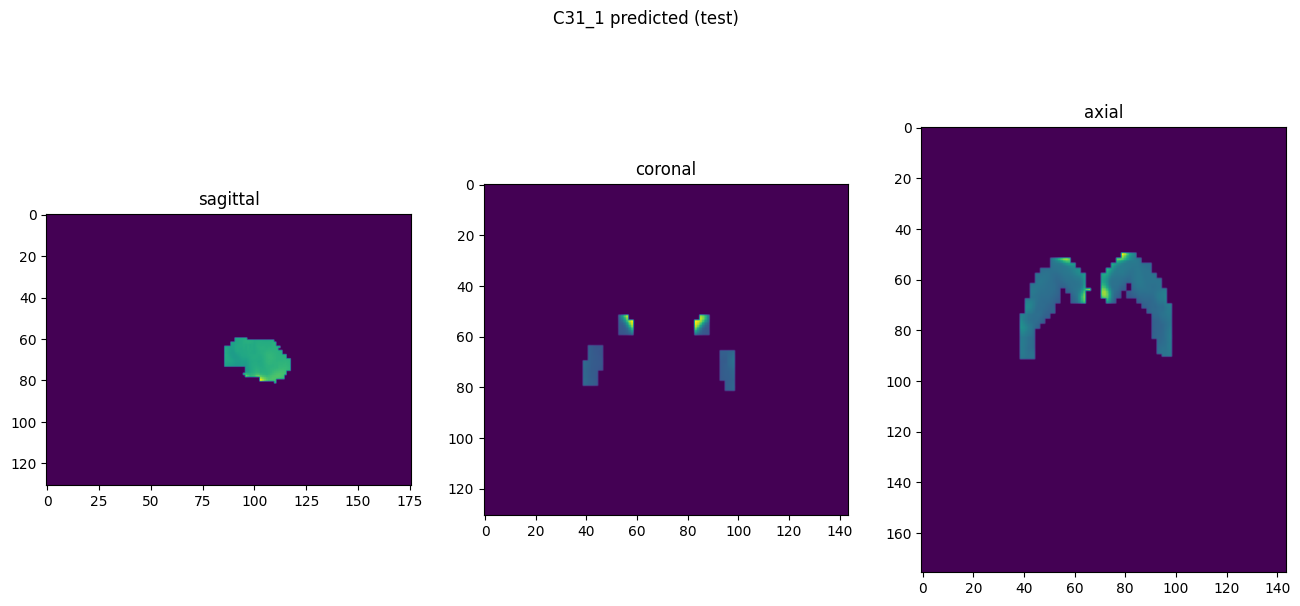

In [10]:
showResults(model, gen, threshold=None, background=False)